In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import copy

## Download Data

In [2]:
all_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor()
    ])

fashion_mnist_train = torchvision.datasets.FashionMNIST(root="fmnist/", download=False, transform=all_transforms)
fashion_mnist_test = torchvision.datasets.FashionMNIST(root="fmnist/", download=False, transform=all_transforms, train=False)

## Construct Splits

In [3]:
fashion_mnist_train_splits = [torch.utils.data.Subset(fashion_mnist_train, torch.where(fashion_mnist_train.train_labels == i)[0]) for i in range(10)]
fashion_mnist_test_splits = [torch.utils.data.Subset(fashion_mnist_test, torch.where(fashion_mnist_test.train_labels == i)[0]) for i in range(10)]

/Users/sebastianlee/envs/cata/lib/python3.8/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [11]:
# fashion_mnist_train_split_dataloaders = [torch.utils.data.DataLoader(fashion_mnist_split, batch_size=1, shuffle=True) for fashion_mnist_split in fashion_mnist_train_splits]
# fashion_mnist_test_split_dataloaders = [torch.utils.data.DataLoader(fashion_mnist_split, batch_size=1, shuffle=True) for fashion_mnist_split in fashion_mnist_test_splits]

## Dataset Interpolation

In [6]:
def _get_dataset_mix(first_binary_classification_dataset, second_binary_classification_dataset, alpha: float):
    """OLD: Mixing on probability of sampling"""
    random_indices_subset_1 = torch.bernoulli(alpha * torch.ones(len(first_binary_classification_dataset)))
    random_indices_subset_2 = torch.bernoulli((1 - alpha) * torch.ones(len(second_binary_classification_dataset)))
    subset_1 = torch.utils.data.Subset(first_binary_classification_dataset, torch.where(random_indices_subset_1)[0])
    subset_2 = torch.utils.data.Subset(second_binary_classification_dataset, torch.where(random_indices_subset_2)[0])
    concatenated_dataset = torch.utils.data.ConcatDataset([subset_1, subset_2])
    return concatenated_dataset

In [42]:
dataset_01 = torch.utils.data.ConcatDataset([fashion_mnist_train_splits[0], fashion_mnist_train_splits[1]])
dataset_78 = torch.utils.data.ConcatDataset([fashion_mnist_train_splits[7], fashion_mnist_train_splits[8]])

dataset_01_test = torch.utils.data.ConcatDataset([fashion_mnist_test_splits[0], fashion_mnist_test_splits[1]])
dataset_78_test = torch.utils.data.ConcatDataset([fashion_mnist_test_splits[7], fashion_mnist_test_splits[8]])

dataloader_01 = torch.utils.data.DataLoader(dataset_01, batch_size=1, shuffle=True)
dataloader_01_test = torch.utils.data.DataLoader(dataset_01_test, batch_size=1, shuffle=True)

dataloader_78 = torch.utils.data.DataLoader(dataset_78, batch_size=1, shuffle=True)
dataloader_78_test = torch.utils.data.DataLoader(dataset_78_test, batch_size=1, shuffle=True)

target_mapping = {0: torch.Tensor([-1.]), 1: torch.Tensor([1.]), 7: torch.Tensor([-1.]), 8: torch.Tensor([1.])}
label_mapping = {0: -1, 1: 1, 7: -1, 8: 1}

## Define Network

In [8]:
input_dim = 32 * 32

class Network(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self._layer1 = nn.Linear(input_dim, 8)
        
        self._layer2a = nn.Linear(8, 1)
        self._layer2b = nn.Linear(8, 1)
        
        self._task = 0
        
    def switch(self, task_index):
        self._task = task_index
        
    def forward(self, x):
        
        x = x.reshape(x.shape[0], -1)
        
        x = F.relu(self._layer1(x))
        
        if self._task == 0:
            y = self._layer2a(x)
        elif self._task == 1:
            y = self._layer2b(x)
        
        return y

## Training Loop

In [21]:
def train(dataloader_1, dataloader_2, alpha, network, epochs, lr, target_mapping):
    
    loss_function = nn.MSELoss()
    optimiser = torch.optim.SGD(params=network.parameters(), lr=lr)
    
    losses = []
    
    for e in range(epochs):
        
        epoch_loss = []
        
        for (x_1, y_1), (x_2, y_2) in zip(iter(dataloader_1), iter(dataloader_2)):
            
            mixed_input = alpha * x_1 + (1 - alpha) * x_2
            
            mapped_y_1 = target_mapping[y_1.item()]
            mapped_y_2 = target_mapping[y_2.item()]
            
            mixed_label = torch.Tensor([np.sign(alpha * mapped_y_1 + (1 - alpha) * mapped_y_2)])
            
            prediction = network(mixed_input)
            loss = loss_function(prediction.flatten(), mixed_label)
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
                    
            epoch_loss.append(loss.item())
        
        print(f"Epoch {e + 1}/{epochs} loss: {np.mean(epoch_loss)}")
        losses.append(np.mean(epoch_loss))
            
    return losses, network

## Test Loop

In [44]:
def test(dataloader_1, dataloader_2, alpha, network, target_mapping):
    
    loss_function = nn.MSELoss()
    
    test_loss = []
    correct_instances = []
    
    with torch.no_grad():

        for (x_1, y_1), (x_2, y_2) in zip(iter(dataloader_1), iter(dataloader_2)):

            mixed_input = alpha * x_1 + (1 - alpha) * x_2

            mapped_y_1 = target_mapping[y_1.item()]
            mapped_y_2 = target_mapping[y_2.item()]

            mixed_label = torch.Tensor([np.sign(alpha * mapped_y_1 + (1 - alpha) * mapped_y_2)])

            prediction = network(mixed_input)
            loss = loss_function(prediction.flatten(), mixed_label)
            correct = (torch.sign(prediction) == mixed_label).item()

            test_loss.append(loss.item())
            correct_instances.append(correct)

    return np.mean(test_loss), sum(correct_instances) / len(correct_instances)

## Task 1 Training

In [22]:
losses, task_1_trained_network = train(dataloader_01, dataloader_78, 1, Network(), 100, 0.01, target_mapping)

Epoch 1/100 loss: 0.1588658816785105
Epoch 2/100 loss: 0.09111098771674078
Epoch 3/100 loss: 0.08195455870012515
Epoch 4/100 loss: 0.07787328904034473
Epoch 5/100 loss: 0.07425716059198796
Epoch 6/100 loss: 0.06767421221543218
Epoch 7/100 loss: 0.06338211366825493
Epoch 8/100 loss: 0.06273099924613831
Epoch 9/100 loss: 0.06017847271035386
Epoch 10/100 loss: 0.05795161803787949
Epoch 11/100 loss: 0.05687095136886982
Epoch 12/100 loss: 0.05293232476017251
Epoch 13/100 loss: 0.05290230780007759
Epoch 14/100 loss: 0.05279714095429693
Epoch 15/100 loss: 0.052533395233592975
Epoch 16/100 loss: 0.05150259036078027
Epoch 17/100 loss: 0.04952641708518081
Epoch 18/100 loss: 0.048490900612972475
Epoch 19/100 loss: 0.0474836511129615
Epoch 20/100 loss: 0.0478142855072321
Epoch 21/100 loss: 0.04585369263976691
Epoch 22/100 loss: 0.04605596386574837
Epoch 23/100 loss: 0.04372176106968829
Epoch 24/100 loss: 0.04403360571295555
Epoch 25/100 loss: 0.04247090278413621
Epoch 26/100 loss: 0.04340151485725

In [45]:
test_loss, test_accuracy = test(dataloader_01_test, dataloader_78_test, 1, task_1_trained_network, target_mapping)

In [46]:
test_accuracy

0.987

In [24]:
test_data = next(iter(dataloader_01_test))
test_inputs = test_data[0]
test_labels = test_data[1]
with torch.no_grad():
    test_outputs = task_1_trained_network(test_inputs)
mapped_test_label = np.array([label_mapping[i] for i in test_labels.numpy()])
accuracy = sum(np.sign(test_outputs.numpy()).flatten() == mapped_test_label) / len(test_inputs)

In [25]:
accuracy

0.987

In [162]:
task_1_trained_network.state_dict()

OrderedDict([('_layer1.weight',
              tensor([[ 0.0113,  0.0289,  0.0323,  ..., -0.0224,  0.0070,  0.0290],
                      [ 0.0134,  0.0121,  0.0211,  ..., -0.0042,  0.0035,  0.0199],
                      [ 0.0299,  0.0243, -0.0155,  ..., -0.0136, -0.0132, -0.0071],
                      ...,
                      [-0.0077,  0.0053,  0.0162,  ..., -0.0605,  0.0052,  0.0065],
                      [ 0.0126,  0.0111, -0.0402,  ...,  0.1217,  0.0784,  0.0037],
                      [ 0.0242, -0.0250, -0.0070,  ...,  0.0225,  0.0309,  0.0209]])),
             ('_layer1.bias',
              tensor([ 2.5517, -0.0107, -0.0045, -1.3789,  1.3958,  2.4391,  1.7133,  3.4518])),
             ('_layer2a.weight',
              tensor([[-0.1633,  0.2989, -0.2756,  0.3890,  0.3104, -0.4713,  0.3037,  0.3088]])),
             ('_layer2a.bias', tensor([-0.5738])),
             ('_layer2b.weight',
              tensor([[ 0.1236, -0.0296, -0.0863,  0.1183,  0.2382, -0.0657, -0.2177,  0.30

In [168]:
task_1_trained_network_copy = copy.deepcopy(task_1_trained_network)

task_1_trained_network_copy.switch(1)
interpolated_dataset = get_dataset_mix(dataset_01, dataset_78, 0)
interpolated_dataloader = torch.utils.data.DataLoader(interpolated_dataset, batch_size=1, shuffle=True)
    
losses, task_2_trained_network = train(dataloader=interpolated_dataloader, network=task_1_trained_network_copy, epochs=10, lr=0.01, target_mapping=target_mapping)

Epoch 1/10 loss: 0.05447167393741591
Epoch 2/10 loss: 0.027725078008859212
Epoch 3/10 loss: 0.023086790268217364
Epoch 4/10 loss: 0.020417353379085526
Epoch 5/10 loss: 0.01904322733255419
Epoch 6/10 loss: 0.01803759840932575
Epoch 7/10 loss: 0.017174486423052596
Epoch 8/10 loss: 0.01696653009879623
Epoch 9/10 loss: 0.016087961287165255
Epoch 10/10 loss: 0.015537311530599679


In [169]:
task_2_trained_network.state_dict()

OrderedDict([('_layer1.weight',
              tensor([[ 0.0113,  0.0287,  0.0321,  ..., -0.0486, -0.0087,  0.0256],
                      [ 0.0134,  0.0121,  0.0211,  ..., -0.0042,  0.0035,  0.0199],
                      [ 0.0299,  0.0243, -0.0155,  ...,  0.0157,  0.0146, -0.0073],
                      ...,
                      [-0.0077,  0.0053,  0.0162,  ..., -0.0530,  0.0109,  0.0065],
                      [ 0.0126,  0.0111, -0.0402,  ...,  0.1195,  0.0777,  0.0037],
                      [ 0.0242, -0.0250, -0.0070,  ...,  0.0153,  0.0285,  0.0206]])),
             ('_layer1.bias',
              tensor([ 2.2371, -0.0107,  1.2138, -1.4359,  1.3263,  2.9868,  2.0667,  3.4411])),
             ('_layer2a.weight',
              tensor([[-0.1633,  0.2989, -0.2756,  0.3890,  0.3104, -0.4713,  0.3037,  0.3088]])),
             ('_layer2a.bias', tensor([-0.5738])),
             ('_layer2b.weight',
              tensor([[ 0.0358, -0.0296, -0.3671,  0.1560,  0.0246, -0.2338, -0.1217, -0.23

In [170]:
task_2_trained_network.switch(0)

with torch.no_grad():
    test_outputs = task_2_trained_network(test_inputs)
    
accuracy = sum(np.sign(test_outputs.numpy()).flatten() == mapped_test_label) / len(test_inputs)

In [171]:
accuracy

0.51

## Task 2

In [ ]:
task_1_accuracies = {}
task_2_accuracies = {}

task_1_losses = {}
task_2_losses = {}

for alpha in np.linspace(0, 1, 20):
    print(alpha)
    task_1_trained_network_copy = copy.deepcopy(task_1_trained_network)
    task_1_trained_network_copy.switch(1)
#     interpolated_dataset = get_dataset_mix(dataset_01, dataset_78, alpha)
#     interpolated_dataloader = torch.utils.data.DataLoader(interpolated_dataset, batch_size=1, shuffle=True)
    
#     interpolated_dataset_test = get_dataset_mix(dataset_01_test, dataset_78_test, alpha)
#     interpolated_dataloader_test = torch.utils.data.DataLoader(interpolated_dataset_test, batch_size=len(interpolated_dataset_test), shuffle=True)
    
    losses, task_2_trained_network = train(dataloader_01, dataloader_78, alpha, Network(), 100, 0.01, target_mapping)
    task_2_loss, task_2_accuracy = test(dataloader_01_test, dataloader_78_test, alpha, task_2_trained_network, target_mapping)
    
    task_2_trained_network.switch(0)
    task_1_loss, task_1_accuracy = test(dataloader_01_test, dataloader_78_test, 1, task_2_trained_network, target_mapping)
    
#     task_2_test_data = next(iter(interpolated_dataloader_test))
#     task_2_test_inputs = task_2_test_data[0]
#     task_2_test_labels = task_2_test_data[1]
#     task_2_test_labels_mapped = np.array([label_mapping[i] for i in task_2_test_labels.numpy()])
    
#     with torch.no_grad():
#         task_2_test_outputs = task_2_trained_network(task_2_test_inputs)
    
#     task_2_accuracy = sum(np.sign(task_2_test_outputs.numpy()).flatten() == task_2_test_labels_mapped) / len(task_2_test_inputs)
    
#     task_2_trained_network.switch(0)
    
#     task_1_test_data = next(iter(dataloader_01_test))
#     task_1_test_inputs = task_1_test_data[0]
#     task_1_test_labels = task_1_test_data[1]
#     task_1_test_labels_mapped = np.array([label_mapping[i] for i in task_1_test_labels.numpy()])
    
#     with torch.no_grad():
#         task_1_test_outputs = task_2_trained_network(task_1_test_inputs)
    
#     task_1_accuracy = sum(np.sign(task_1_test_outputs.numpy()).flatten() == task_1_test_labels_mapped) / len(task_1_test_inputs)
    
#     print(task_1_accuracy)
#     print(task_2_accuracy)
    
    task_2_accuracies[alpha] = task_2_accuracy
    task_1_accuracies[alpha] = task_1_accuracy
    
    task_1_losses[alpha] = task_1_loss
    task_2_losses[alpha] = task_2_loss

0.0
Epoch 1/100 loss: 0.06868406600352739
Epoch 2/100 loss: 0.032788023214048785
Epoch 3/100 loss: 0.025402144108759038
Epoch 4/100 loss: 0.02223492078672801
Epoch 5/100 loss: 0.02059890863472718
Epoch 6/100 loss: 0.019038617346230514
Epoch 7/100 loss: 0.018707659077793762
Epoch 8/100 loss: 0.017676065054317056
Epoch 9/100 loss: 0.016790369800422207
Epoch 10/100 loss: 0.01628994019265593
Epoch 11/100 loss: 0.01622671794483086
Epoch 12/100 loss: 0.015423004508470475
Epoch 13/100 loss: 0.015322308858765897
Epoch 14/100 loss: 0.014918374572002832
Epoch 15/100 loss: 0.014846146110441858
Epoch 16/100 loss: 0.014102532518473297
Epoch 17/100 loss: 0.013735831681221111
Epoch 18/100 loss: 0.012488326440257297
Epoch 19/100 loss: 0.011724683211468925
Epoch 20/100 loss: 0.011322160958655821
Epoch 21/100 loss: 0.01115089626527794
Epoch 22/100 loss: 0.010693621409670168
Epoch 23/100 loss: 0.010744558653767555
Epoch 24/100 loss: 0.010632201543020968
Epoch 25/100 loss: 0.010273131986751243
Epoch 26/10

In [155]:
task_1_accuracies

{0.0: 0.503,
 0.1111111111111111: 0.9235,
 0.2222222222222222: 0.969,
 0.3333333333333333: 0.9675,
 0.4444444444444444: 0.9815,
 0.5555555555555556: 0.975,
 0.6666666666666666: 0.984,
 0.7777777777777777: 0.9825,
 0.8888888888888888: 0.9875,
 1.0: 0.988}

In [156]:
task_2_accuracies

{0.0: 0.9975,
 0.1111111111111111: 0.9616724738675958,
 0.2222222222222222: 0.9699849924962481,
 0.3333333333333333: 0.9803052683407188,
 0.4444444444444444: 0.9850894632206759,
 0.5555555555555556: 0.9824390243902439,
 0.6666666666666666: 0.9798285426122038,
 0.7777777777777777: 0.9831181727904668,
 0.8888888888888888: 0.986815415821501,
 1.0: 0.9845}

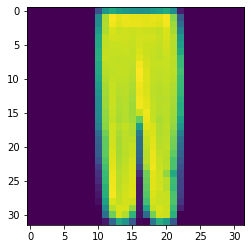

In [127]:
plt.imshow(next(di)[0].numpy().squeeze())

In [131]:
sum(torch.bernoulli(0.5 * torch.ones(500)))

tensor(264.)

<ipython-input-159-82b3b645d734>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


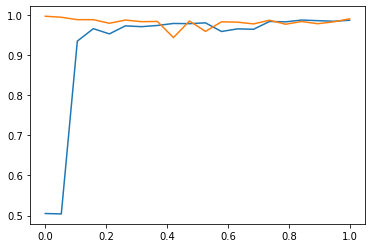

In [159]:
fig = plt.figure()
plt.plot(task_1_accuracies.keys(), task_1_accuracies.values())
plt.plot(task_2_accuracies.keys(), task_2_accuracies.values())
fig.show()